In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import gc
import warnings
warnings.filterwarnings("ignore")
import sys
import time
####
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
####
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
import torchvision.transforms as transforms
import torchvision
##
from fastprogress import master_bar, progress_bar
from PIL import Image
gc.collect()

62

Device 

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:
device = get_default_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

In [64]:
data_directory = os.path.join(os.path.dirname(os.getcwd()),"data")
data_path = Path(data_directory)
full_train_df = pd.read_csv(os.path.join(data_path, Path('archive/train.csv')))
full_valid_df = pd.read_csv(os.path.join(data_path, Path('archive/valid.csv')))

full_train_df['patient'] = full_train_df.Path.str.split('/',n=3,expand=True)[2]
full_train_df['study'] = full_train_df.Path.str.split('/',n=4,expand=True)[3]

full_valid_df['patient'] = full_valid_df.Path.str.split(pat='/',n=3,expand=True)[2]
full_valid_df['study'] = full_valid_df.Path.str.split(pat='/', n=4,expand=True)[3]


cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices']

data_df = []



for i in cols:
    minusOneVal = sum(np.where(full_train_df[i] == -1,1,0))
    oneVal = sum(np.where(full_train_df[i] == 1,1,0))
    zeroVal = sum(np.where(full_train_df[i] == 0,1,0))
    #nanVal = sum(np.where(full_train_df[i] == np.NaN ,1,0))
    nanVal = full_train_df[i].isnull().sum()
    data_df.append([i,minusOneVal,oneVal,zeroVal,nanVal])
    
data_df = pd.DataFrame(data_df)
data_df.columns = ['Label','-1','1','0','Nan']
data_df



,Label,-1,1,0,Nan
0,No Finding,0,22381,0,201033
1,Enlarged Cardiomediastinum,12403,10798,21638,178575
2,Cardiomegaly,8087,27000,11116,177211
3,Lung Opacity,5598,105581,6599,105636
4,Lung Lesion,1488,9186,1270,211470
5,Edema,12984,52246,20726,137458
6,Consolidation,27742,14783,28097,152792
7,Pneumonia,18770,6039,2799,195806
8,Atelectasis,33739,33376,1328,154971
9,Pneumothorax,3145,19448,56341,144480


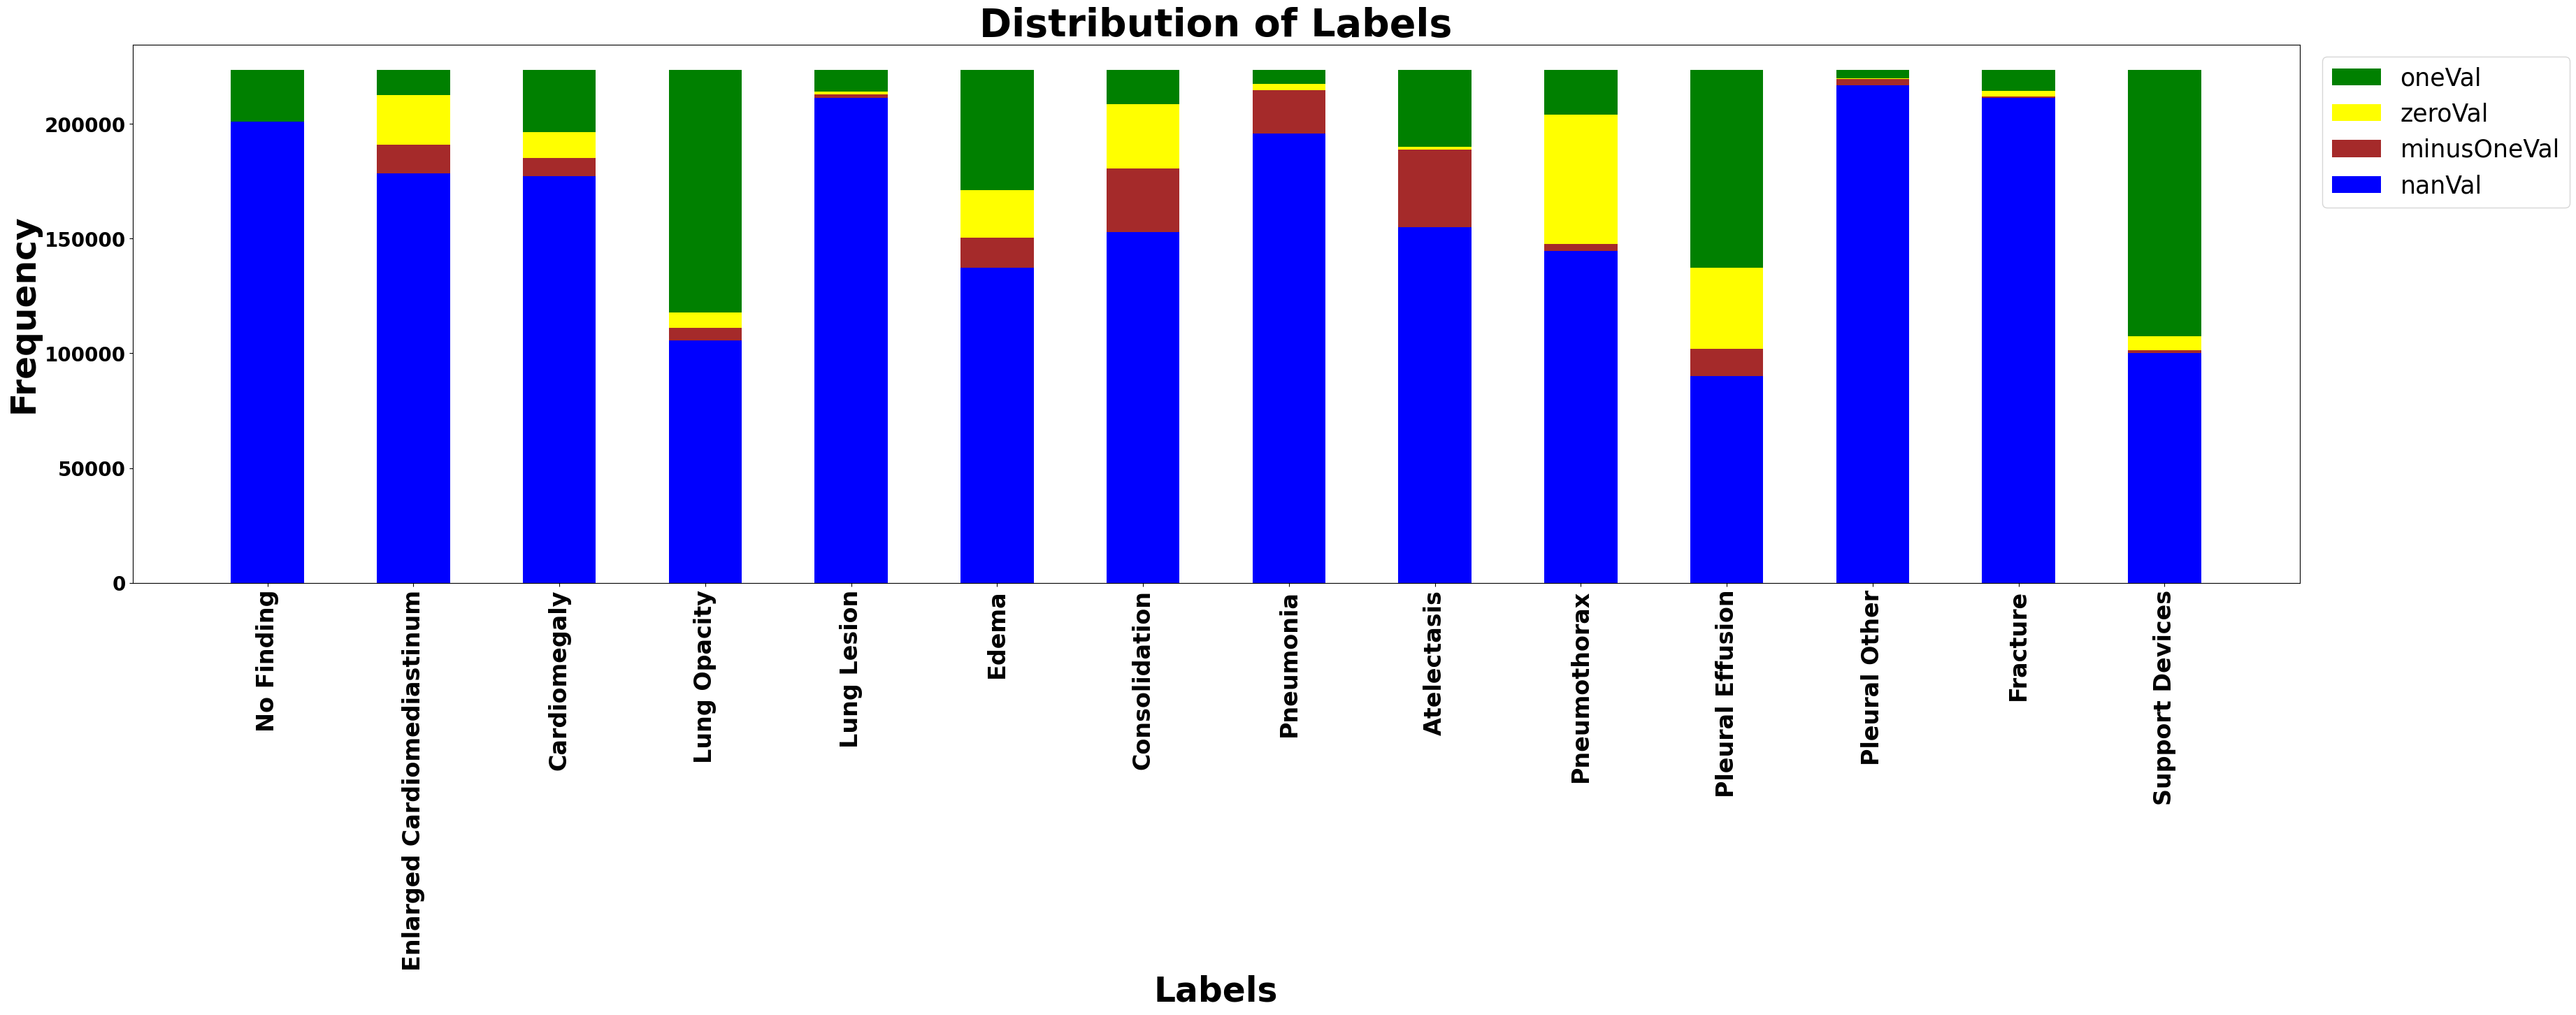

In [65]:
plt.figure(figsize=(40,10))
Label = data_df['Label']
nanVal = data_df['Nan']
minusOneVal = data_df['-1']
zeroVal = data_df['0']
oneVal = data_df['1']

ind = [x for x, _ in enumerate(Label)]

plt.bar(Label, oneVal, width=0.5, label='oneVal', color='green', bottom=zeroVal+minusOneVal+nanVal)
plt.bar(Label, zeroVal, width=0.5, label='zeroVal', color='yellow', bottom=minusOneVal+nanVal)
plt.bar(Label, minusOneVal, width=0.5, label='minusOneVal', color='brown',bottom=nanVal)
plt.bar(Label, nanVal, width=0.5, label='nanVal', color='blue')

plt.yticks(fontsize=20,fontweight='bold')

plt.xticks(ind, Label,fontsize=24,fontweight='bold',rotation=90)
plt.ylabel("Frequency",fontsize=35,fontweight='bold')
plt.xlabel("Labels",fontsize=35,fontweight='bold')
plt.legend(bbox_to_anchor=(1.005, 1),fontsize=25)
#plt.legend(bbox_to_anchor=(1.005, 1))
plt.title("Distribution of Labels",fontsize=40, fontweight='bold')

plt.show()